# UAV RID SPOOF CLASSIFIER - Machine Learning Models

---

This script trains and evaluates three ML models (1D CNN, Random Forest, and
Logistic Regression) to classify spoofed RID message packets based on their
Radio Frequency Fingerprints (RFFs).

Models:
*   1D Convolutional Neural Network (deep learning on raw I/Q)
*   Random Forest (traditional ML with extracted features)
*   Logistic Regression (baseline classifier)



Input: 'uav_dataset.csv' containing raw I/Q samples and labels
Output: Model performance metrics and comparison visualizations

Dependencies:
```
    pip install pandas numpy scikit-learn matplotlib tensorflow imbalanced-learn
```




In [3]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                            classification_report, accuracy_score, f1_score)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, BatchNormalization, Dropout,
                                     Conv1D, MaxPooling1D, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Data Preprocessing

---

Load raw I/Q signal data from CSV. The signal format is:
I0, Q0, I1, Q1, ..., In, Qn (first 2000 samples of transmitted RID message).
#
Steps:
1. Load dataset and separate features (I/Q) from labels
2. Reshape to (samples, I/Q pairs, 2 channels)
3. Split into train (70%), validation (15%), test (15%)
4. Apply StandardScaler normalization
5. Compute class weights for imbalanced data handling

In [4]:
df = pd.read_csv("uav_dataset.csv")

In [5]:
# After loading data
x = df.drop('Label', axis=1).values  # All IQ columns
y = df['Label'].values  # Label column

# Reshape to show I/Q pairs: (samples, 10000 pairs, 2 features per pair)
x = x.reshape(x.shape[0], -1, 2)

In [6]:
# Split dataset into x_train, y_train (70% of data used for training) and x_temp and y_temp (30% of data to be split further)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y,
    stratify = y,
    random_state = 42,
    test_size = 0.3 # 30% test
)

# Split x_temp and y_temp so that half (x_val, y_val) is used for validation and the other half (x_test, y-test) is used for testing
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp,
    stratify = y_temp,
    random_state = 42,
    test_size = 0.5 # 50% split
)

In [7]:
# Scaling (standard Scaler)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(x_train.shape[0], -1)).reshape(x_train.shape)
x_val_scaled = scaler.transform(x_val.reshape(x_val.shape[0], -1)).reshape(x_val.shape)
x_test_scaled = scaler.transform(x_test.reshape(x_test.shape[0], -1)).reshape(x_test.shape)

In [8]:
# Class names fand weights
class_names = ['CITIZEN', 'UAV_ATTACK', 'GROUND_ATTACK']
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

## Model Training

### Model \# 1: 1D CNN

In [9]:
#model
model_cnn = Sequential([
    Input(shape=(x_train_scaled.shape[1], 2)),

    Conv1D(32, kernel_size=7, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(len(class_names), activation='softmax')
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 4000, 32)       │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2000, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2000, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1000, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1000, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,835 (175.14 KB)

 Trainable params: 44,387 (173.39 KB)

 Non-trainable params: 448 (1.75 KB)

In [10]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [11]:
# Train CNN
history = model_cnn.fit(
    x_train_scaled, y_train,
    validation_data=(x_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.6014 - loss: 0.9608 - val_accuracy: 0.1745 - val_loss: 1.4145 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 600ms/step - accuracy: 0.7820 - loss: 0.5797 - val_accuracy: 0.1678 - val_loss: 3.7922 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 682ms/step - accuracy: 0.8434 - loss: 0.4776 - val_accuracy: 0.1678 - val_loss: 6.4395 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 571ms/step - accuracy: 0.8621 - loss: 0.3890 - val_accuracy: 0.1678 - val_loss: 6.9992 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 567ms/step - accuracy: 0.8673 - loss: 0.3773 - val_accuracy: 0.1812 - val_loss: 5.8233 - learning_rate: 0.0010
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 551ms/step - accuracy: 0.8826 - loss: 0.3601 - val_accuracy: 0.2327 - val_loss: 4.1370 - learning_rate: 0.0010
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 539ms/step - accuracy: 0.8954 - loss

In [12]:
# Evaluate CNN
y_pred_cnn = np.argmax(model_cnn.predict(x_test_scaled), axis=1)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

print(f"\n1D-CNN Results:")
print(classification_report(y_test, y_pred_cnn, target_names=class_names, digits=4, zero_division=0))

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step

1D-CNN Results:
               precision    recall  f1-score   support

      CITIZEN     0.9903    0.9031    0.9447       227
   UAV_ATTACK     0.9790    0.9655    0.9722       145
GROUND_ATTACK     0.7755    1.0000    0.8736        76

     accuracy                         0.9397       448
    macro avg     0.9150    0.9562    0.9302       448
 weighted avg     0.9502    0.9397    0.9415       448



### Model \#2: Random Forest

In [13]:
# Feature extraction
def extract_features(X):
    """Extract statistical features from I/Q samples for traditional ML."""
    features = []
    for sample in X:
        I, Q = sample[:, 0], sample[:, 1]
        amplitude = np.sqrt(I**2 + Q**2)
        phase = np.arctan2(Q, I)

        feat = [
            # Amplitude stats
            np.mean(amplitude), np.std(amplitude), np.max(amplitude), np.min(amplitude),
            # I/Q stats (captures imbalance)
            np.mean(I), np.std(I), np.mean(Q), np.std(Q),
            np.std(I) / (np.std(Q) + 1e-10),  # I/Q gain ratio
            # Phase stats
            np.mean(phase), np.std(phase),
            # Higher-order stats
            np.mean(amplitude**2),  # Power
            np.mean(I**2 - Q**2),   # I/Q power difference
        ]
        features.append(feat)
    return np.array(features)

In [14]:
# Extract features
x_train_feat = extract_features(x_train_scaled)
x_val_feat = extract_features(x_val_scaled)
x_test_feat = extract_features(x_test_scaled)

In [15]:
# Train Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_rf.fit(x_train_feat, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [16]:
# Evaluate Random Forest
y_pred_rf = model_rf.predict(x_test_feat)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Random Forest Results:")
print(classification_report(y_test, y_pred_rf, target_names=class_names, digits=4, zero_division=0))

Random Forest Results:
               precision    recall  f1-score   support

      CITIZEN     0.8814    0.9163    0.8985       227
   UAV_ATTACK     0.9437    0.9241    0.9338       145
GROUND_ATTACK     0.8286    0.7632    0.7945        76

     accuracy                         0.8929       448
    macro avg     0.8845    0.8679    0.8756       448
 weighted avg     0.8926    0.8929    0.8923       448



### Model \#3: Logistic Regression

In [17]:
# Train Logistic Regression
model_lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model_lr.fit(x_train_feat, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [18]:
# Evaluate Logistic Regression
y_pred_lr = model_lr.predict(x_test_feat)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')

print(f"Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr, target_names=class_names, digits=4, zero_division=0))

Logistic Regression Results:
               precision    recall  f1-score   support

      CITIZEN     0.8872    0.7621    0.8199       227
   UAV_ATTACK     0.9315    0.9379    0.9347       145
GROUND_ATTACK     0.5514    0.7763    0.6448        76

     accuracy                         0.8214       448
    macro avg     0.7900    0.8255    0.7998       448
 weighted avg     0.8446    0.8214    0.8274       448



### Result Summary

In [23]:
print(f"{'Model':<25} {'Accuracy':<12} {'F1 Score':<12}")
print("-"*50)
print(f"{'1D-CNN':<25} {acc_cnn:<12.4f} {f1_cnn:<12.4f}")
print(f"{'Random Forest':<25} {acc_rf:<12.4f} {f1_rf:<12.4f}")
print(f"{'Logistic Regression':<25} {acc_lr:<12.4f} {f1_lr:<12.4f}")

Model                     Accuracy     F1 Score    
--------------------------------------------------
1D-CNN                    0.9397       0.9415      
Random Forest             0.8929       0.8923      
Logistic Regression       0.8214       0.8274      


## Result Visualizations

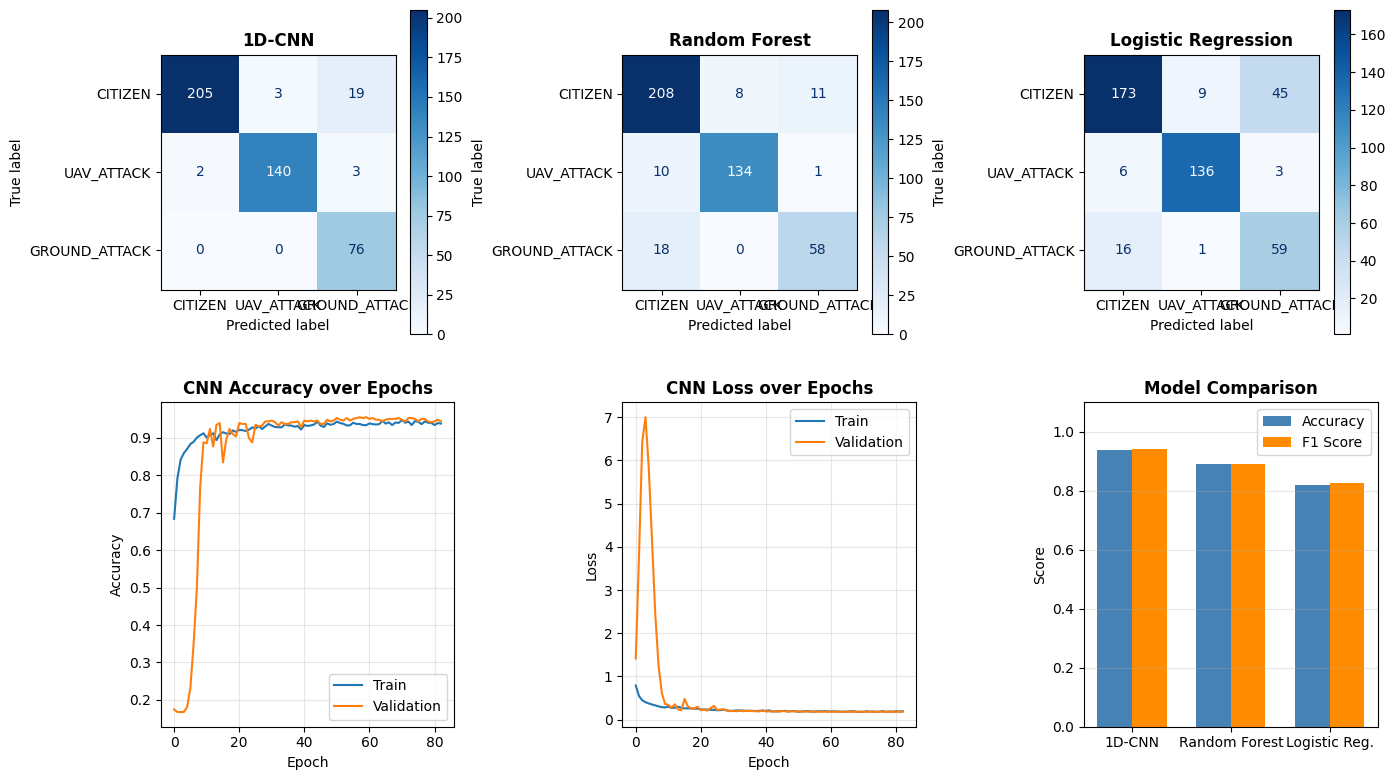

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Row 1: Confusion Matrices
for idx, (y_pred, name) in enumerate([(y_pred_cnn, '1D-CNN'),
                                       (y_pred_rf, 'Random Forest'),
                                       (y_pred_lr, 'Logistic Regression')]):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[0, idx], cmap=plt.cm.Blues)
    axes[0, idx].set_title(f'{name}', fontweight='bold')

# Row 2: CNN Training History + Model Comparison
axes[1, 0].plot(history.history['accuracy'], label='Train')
axes[1, 0].plot(history.history['val_accuracy'], label='Validation')
axes[1, 0].set_title('CNN Accuracy over Epochs', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history.history['loss'], label='Train')
axes[1, 1].plot(history.history['val_loss'], label='Validation')
axes[1, 1].set_title('CNN Loss over Epochs', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Model comparison bar chart
models = ['1D-CNN', 'Random Forest', 'Logistic Reg.']
accuracies = [acc_cnn, acc_rf, acc_lr]
f1_scores = [f1_cnn, f1_rf, f1_lr]

x_pos = np.arange(len(models))
width = 0.35

axes[1, 2].bar(x_pos - width/2, accuracies, width, label='Accuracy', color='steelblue')
axes[1, 2].bar(x_pos + width/2, f1_scores, width, label='F1 Score', color='darkorange')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Model Comparison', fontweight='bold')
axes[1, 2].set_xticks(x_pos)
axes[1, 2].set_xticklabels(models)
axes[1, 2].legend()
axes[1, 2].set_ylim([0, 1.1])
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison_results.png', dpi=150)
plt.show()
